# Vignette 5: Multi-omics validation - Recovery of dysregulated kinases in response to cancer mutations

In this vignette, we will explore another way to evaluate networks, this time using a more biological approach. We will use the Clinical Proteomic Tumor Analysis Consortium (CPTAC) data, a compendium of tissue samples from 10 different cancer types, along with their respective adjacent, healthy tissue, samples.

> Ellis, M. J. et al. Connecting genomic alterations to cancer biology with proteomics: the NCI Clinical Proteomic Tumor Analysis Consortium. *Cancer Discov. 3, 1108–1112 (2013)*.

> Li, Y. et al. Proteogenomic data and resources for pan-cancer analysis. *Cancer Cell 41, 1397–1406 (2023)*.


In this setting, we will use a multiomics approach as follows:
* First, we will identify the most differentially abundant receptors in the proteomics profiles between healthy and tumor samples. We assume that if they are differentially abundant, they will be activated/inhibited.
* Second, we will use the transcriptomics data to perform TF enrichment analysis, in order to get the TFs that are dysregulated in the tumor samples compared to the healthy control.
* Lastly, we will use phosphoproteomics to perform kinase activity estimation and then evaluate the level of dysregulation in the resulting subnetwork. Hopefully, we will be able to assess whether these subnetworks contain a higher share of dysregulated elements compared to the overall phosphoproteome, and against random models. For more information about this specific evaluation, please check the details [here](../benchmarks.html#recovery-of-dysregulated-kinases).

With this vignette, we want to showcase a real example of an end-to-end workflow, starting from raw data and ending in a set of metrics we can use to evaluate network inference methodologies. If you are not familiar with the basics of **Networkcommons**, please refer to our previous vignettes.

## 1. Data processing

In [1]:
import networkcommons as nc
import pandas as pd
import numpy as np
import decoupler as dc

NetworkCommons provide a series of util functions to retrieve the CPTAC tables in an easy way. We can use the `cptac_cohorsize` function to visualise the different cancer samples, the `cptac_fileinfo` function to visualise the different files, and the `cptac_datatypes`. Finally, we will get the tables using the `cptac_table()` function. We will skip to this last function, but feel free to try them all :)

In [2]:
cptac_transcriptomics_tumor = nc.data.omics.cptac_table('rna', 'LSCC', 'RNAseq_gene_RSEM_coding_UQ_1500_log2_Tumor').set_index('idx').add_suffix('_tumor').reset_index()
cptac_proteomics_tumor = nc.data.omics.cptac_table('proteome', 'LSCC', 'proteomics_gene_abundance_log2_reference_intensity_normalized_Tumor').set_index('idx').add_suffix('_tumor').reset_index()
cptac_phosphoproteomics_tumor = nc.data.omics.cptac_table('phosphoproteome', 'LSCC', 'phospho_site_abundance_log2_reference_intensity_normalized_Tumor').set_index('idx').add_suffix('_tumor').reset_index()
cptac_transcriptomics_ctrl = nc.data.omics.cptac_table('rna', 'LSCC', 'RNAseq_gene_RSEM_coding_UQ_1500_log2_Normal').set_index('idx').add_suffix('_ctrl').reset_index()
cptac_proteomics_ctrl = nc.data.omics.cptac_table('proteome', 'LSCC', 'proteomics_gene_abundance_log2_reference_intensity_normalized_Normal').set_index('idx').add_suffix('_ctrl').reset_index()
cptac_phosphoproteomics_ctrl = nc.data.omics.cptac_table('phosphoproteome', 'LSCC', 'phospho_site_abundance_log2_reference_intensity_normalized_Normal').set_index('idx').add_suffix('_ctrl').reset_index()
cptac_meta = nc.data.omics.cptac_table('metadata', 'LSCC', 'meta')
cptac_meta.drop(0, axis=0, inplace=True)

The CPTAC raw files contain the Normal and Tumour groups in separate files. In addition, the metadata is set at the patient level, not at the sample level, which is what we look for. This can be handled easily with the `cptac_extend_dataframe` function:

In [3]:
cptac_meta = nc.data.omics.cptac_extend_dataframe(cptac_meta)

In [4]:
transcriptomics = pd.merge(cptac_transcriptomics_ctrl, cptac_transcriptomics_tumor, left_on='idx', right_on='idx', how='outer', suffixes=('_ctrl', '_tumor'))
proteomics = pd.merge(cptac_proteomics_ctrl, cptac_proteomics_tumor, left_on='idx', right_on='idx', how='outer', suffixes=('_ctrl', '_tumor'))
phosphoproteomics = pd.merge(cptac_phosphoproteomics_ctrl, cptac_phosphoproteomics_tumor, left_on='idx', right_on='idx', how='outer', suffixes=('_ctrl', '_tumor'))

Now, since we have duplicated the samples by adding either _ctrl or _tumor suffixes, we need to update the according metadata

In [5]:
transcriptomics_meta = pd.DataFrame({'sample_ID': transcriptomics.set_index('idx').columns.to_list()})
transcriptomics_meta['group'] = transcriptomics_meta['sample_ID'].apply(lambda x: 'ctrl' if '_ctrl' in x else 'tumor')

In [6]:
transcriptomics_meta = pd.merge(transcriptomics_meta, cptac_meta, left_on='sample_ID', right_on='sample_ID', how='left')
transcriptomics_meta = transcriptomics_meta[['sample_ID', 'group', 'Age', 'Sex', 'Tumor_Size_cm', 'Tumor_necrosis']]

In [7]:
proteomics_meta = pd.DataFrame({'sample_ID': proteomics.set_index('idx').columns.to_list()})
proteomics_meta['group'] = proteomics_meta['sample_ID'].apply(lambda x: 'ctrl' if '_ctrl' in x else 'tumor')

In [8]:
proteomics_meta = pd.merge(proteomics_meta, cptac_meta, left_on='sample_ID', right_on='sample_ID', how='left')
proteomics_meta = proteomics_meta[['sample_ID', 'group', 'Age', 'Sex', 'Tumor_Size_cm', 'Tumor_necrosis']]

In [9]:
phosphoproteomics_meta = pd.DataFrame({'sample_ID': phosphoproteomics.set_index('idx').columns.to_list()})
phosphoproteomics_meta['group'] = phosphoproteomics_meta['sample_ID'].apply(lambda x: 'ctrl' if '_ctrl' in x else 'tumor')

In [10]:
phosphoproteomics_meta = pd.merge(phosphoproteomics_meta, cptac_meta, left_on='sample_ID', right_on='sample_ID', how='left')
phosphoproteomics_meta = phosphoproteomics_meta[['sample_ID', 'group', 'Age', 'Sex', 'Tumor_Size_cm', 'Tumor_necrosis']]

Since NAs in proteomics and phosphoproteomics are quite ubiquitous, we will remove those rows which have a NA content above 10%. Since limma can handle NAs, we will not perform any filling strategy.

In [11]:
transcriptomics = nc.utils.handle_missing_values(transcriptomics)

Number of genes removed: 0


In [12]:
proteomics = nc.utils.handle_missing_values(proteomics, threshold=0.1)

Number of genes removed: 3318


In [13]:
phosphoproteomics = nc.utils.handle_missing_values(phosphoproteomics, threshold=0.1)

Number of genes removed: 56800


As a quality control metric, we can plot PCAs to see if there are differences between tumor and control samples.

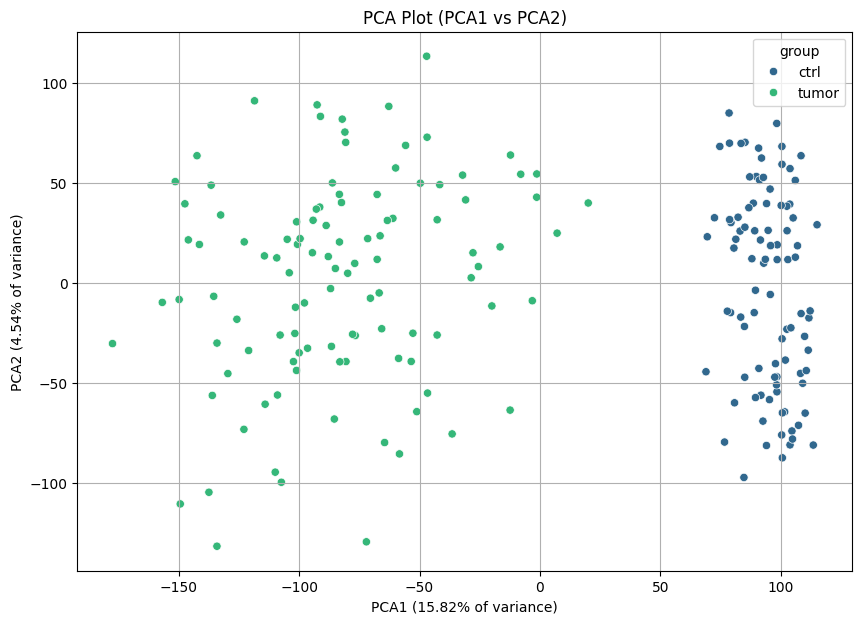

,PCA1,PCA2,group
0,106.909831,18.647101,ctrl
1,79.127035,-14.830272,ctrl
2,83.073833,26.008237,ctrl
3,80.513726,17.490579,ctrl
4,115.026522,29.164087,ctrl


In [14]:
nc.visual.plot_pca(transcriptomics, transcriptomics_meta).head()

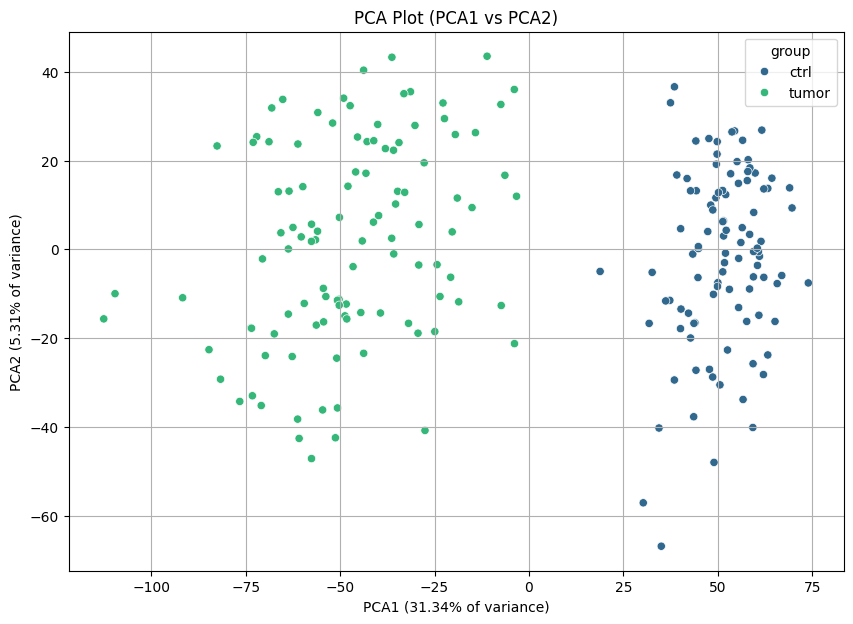

,PCA1,PCA2,group
0,43.622306,-37.733104,ctrl
1,44.305112,13.214244,ctrl
2,49.847993,24.287766,ctrl
3,59.430243,-6.199675,ctrl
4,48.995198,-48.027032,ctrl


In [15]:
nc.visual.plot_pca(phosphoproteomics, phosphoproteomics_meta).head()

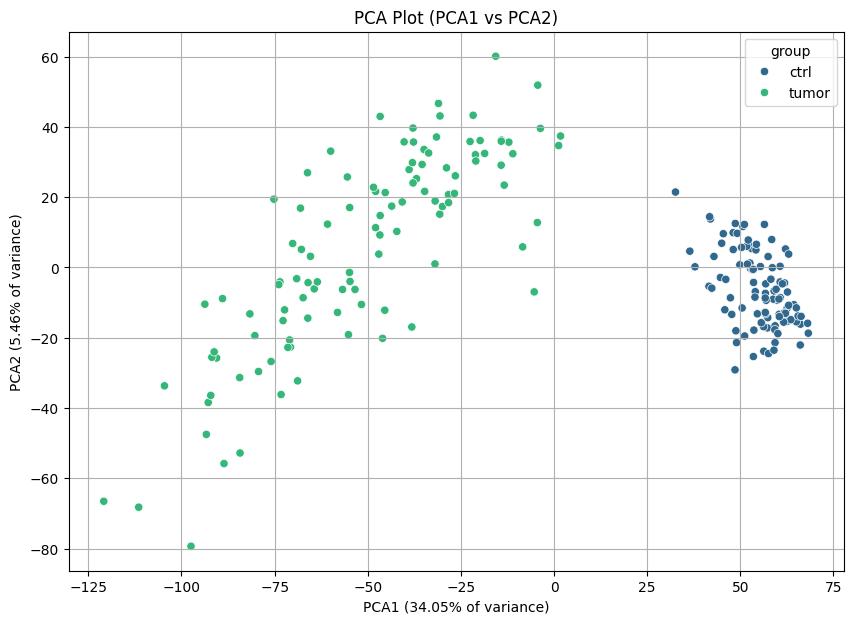

,PCA1,PCA2,group
0,56.460184,12.249534,ctrl
1,50.674229,11.655027,ctrl
2,58.424016,7.944419,ctrl
3,62.538869,-11.643733,ctrl
4,59.310804,-21.416609,ctrl


In [16]:
nc.visual.plot_pca(proteomics, proteomics_meta).head()

And there are! We can easily differentiate the healthy and tumor tissues.

Now, since the data is indexed using ENSEMBL IDs, but our prior-knowledge network is in gene symbols, we will use the `get_ensembl_mappings()` and `convert_ensembl_to_gene_symbol()` to convert them.

In [17]:
ensembl_mapping = nc.data.omics.get_ensembl_mappings()

In [18]:
transcriptomics_renamed = nc.data.omics.convert_ensembl_to_gene_symbol(transcriptomics, ensembl_mapping)
proteomics_renamed = nc.data.omics.convert_ensembl_to_gene_symbol(proteomics, ensembl_mapping)

For phosphoproteomics, since we want to keep the phosphosite-level information, we need to translate the ensembl ids and then concatenate them to the phosphosite-specific fifteenmer.

In [19]:
phosphoproteomics[['gene', 'prot', 'psite', 'seq', 'n']] = phosphoproteomics['idx'].str.split('|', expand=True)
phosphoproteomics.drop('idx', inplace=True, axis=1)

In [20]:
phospho_renamed = nc.data.omics.convert_ensembl_to_gene_symbol(phosphoproteomics, ensembl_mapping, column_name='gene')

In [21]:
phospho_renamed['gene_symbol'] = phospho_renamed['gene_symbol'] + '_' + phospho_renamed['seq']
phospho_renamed.drop(columns=['seq', 'prot', 'psite', 'n'], inplace=True)

Now, we will perform differential expression analysis. Since neither of the three files contain raw counts, which is the input for DESeq2 (the implemented DE pipeline in NetworkCommons), we have to use another method. Here, we will use a combination of variance stabilising normalization and limma, via FLOP:

> Paton et al., Assessing the impact of transcriptomics data analysis pipelines on downstream functional enrichment results. *Nucleic Acids Research, 2024*.https://doi.org/10.1093/nar/gkae552


<div class="alert alert-warning">

**Warning**
    
Bear in mind that the Poetry environment does not contain any of the necessary R packages to run FLOP. In order to run the following chunks within this notebook, you will have to create a conda environment and change the running interpreter. If you want to use FLOP, please check [the FLOP repository](https://github.com/saezlab/flop) for instructions. If you have already your DE files, then you can import them and go directly to the next section.

</div>

We need first to export the files to tsv format, both the matrices and metadata.

In [23]:
transcriptomics_renamed.to_csv('./flop_input/rna/rna__countdata.tsv', index=False, sep='\t')
proteomics_renamed.to_csv('./flop_input/prot/prot__countdata.tsv', index=False, sep='\t')
phospho_renamed.to_csv('./flop_input/phospho/phospho__countdata.tsv', index=False, sep='\t')
transcriptomics_meta.to_csv('./flop_input/rna/rna__metadata.tsv', index=False, sep='\t')
proteomics_meta.to_csv('./flop_input/prot/prot__metadata.tsv', index=False, sep='\t')
phosphoproteomics_meta.to_csv('./flop_input/phospho/phospho__metadata.tsv', index=False, sep='\t')

In [24]:
contrast = pd.DataFrame({'group1': 'tumor', 'group2': 'ctrl'}, index=[0])
contrast.to_csv('./flop_input/rna/rna__contrast.tsv', index=False, sep='\t')
contrast.to_csv('./flop_input/prot/prot__contrast.tsv', index=False, sep='\t')
contrast.to_csv('./flop_input/phospho/phospho__contrast.tsv', index=False, sep='\t')

Now we can launch FLOP:

In [ ]:
%%bash
nextflow -C $HOME/flop/flop.config run $HOME/flop/flop.nf -params-file $HOME/networkcommons/flop_run/params_flop.json -profile desktop --data_folder $HOME/networkcommons/data/flop_input --outdir .

All done! Now we can reimport the files as dataframes:

In [22]:
de_transcr = pd.read_csv('./flop_results/diffexp/rna__deresults.tsv', sep='\t', index_col='ID')
de_transcr.columns = de_transcr.columns.str.replace('__unfiltered__log2quant+limma__tumor_v_ctrl__rna__NA', '')

de_prot = pd.read_csv('./flop_results/diffexp/prot__deresults.tsv', sep='\t', index_col='ID')
de_prot.columns = de_prot.columns.str.replace('__unfiltered__log2quant+limma__tumor_v_ctrl__prot__NA', '')

de_phospho = pd.read_csv('./flop_results/diffexp/phospho__deresults.tsv', sep='\t', index_col='ID')
de_phospho.columns = de_phospho.columns.str.replace('__unfiltered__log2quant+limma__tumor_v_ctrl__phospho__NA', '')

## 2. Prior knowledge and inputs

Now that we have our data preprocessed, we can proceed to defining the inputs of the network inference methods. For the upstream layer, we will identify the most abundant receptors (using information from LIANA) in the proteome. For the downstream layer, we will perform TF activity estimation using the transcriptomics data.

In [47]:
liana_receptors = nc.data.network.get_lianaplus()
receptors = set(liana_receptors.target)
receptors_prot = de_prot[de_prot.index.isin(receptors)]
top_receptors = receptors_prot.sort_values(by='stat', key=lambda x: x.abs(), ascending=False).head(5)
source_dict = top_receptors['stat'].to_dict()

We can see the overall abundance of these receptors in the original data, as well as the differential abundance between groups for each of the selected receptors.

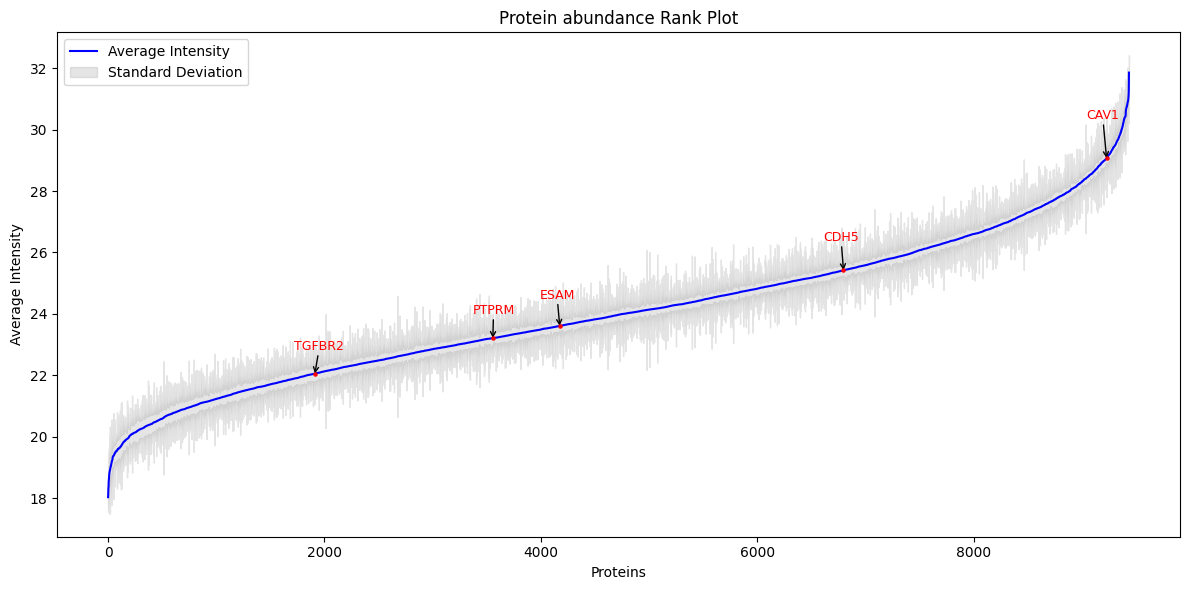

In [48]:
p = nc.visual.plot_rank(proteomics_renamed, bio_ids=source_dict.keys(), id_column='gene_symbol')

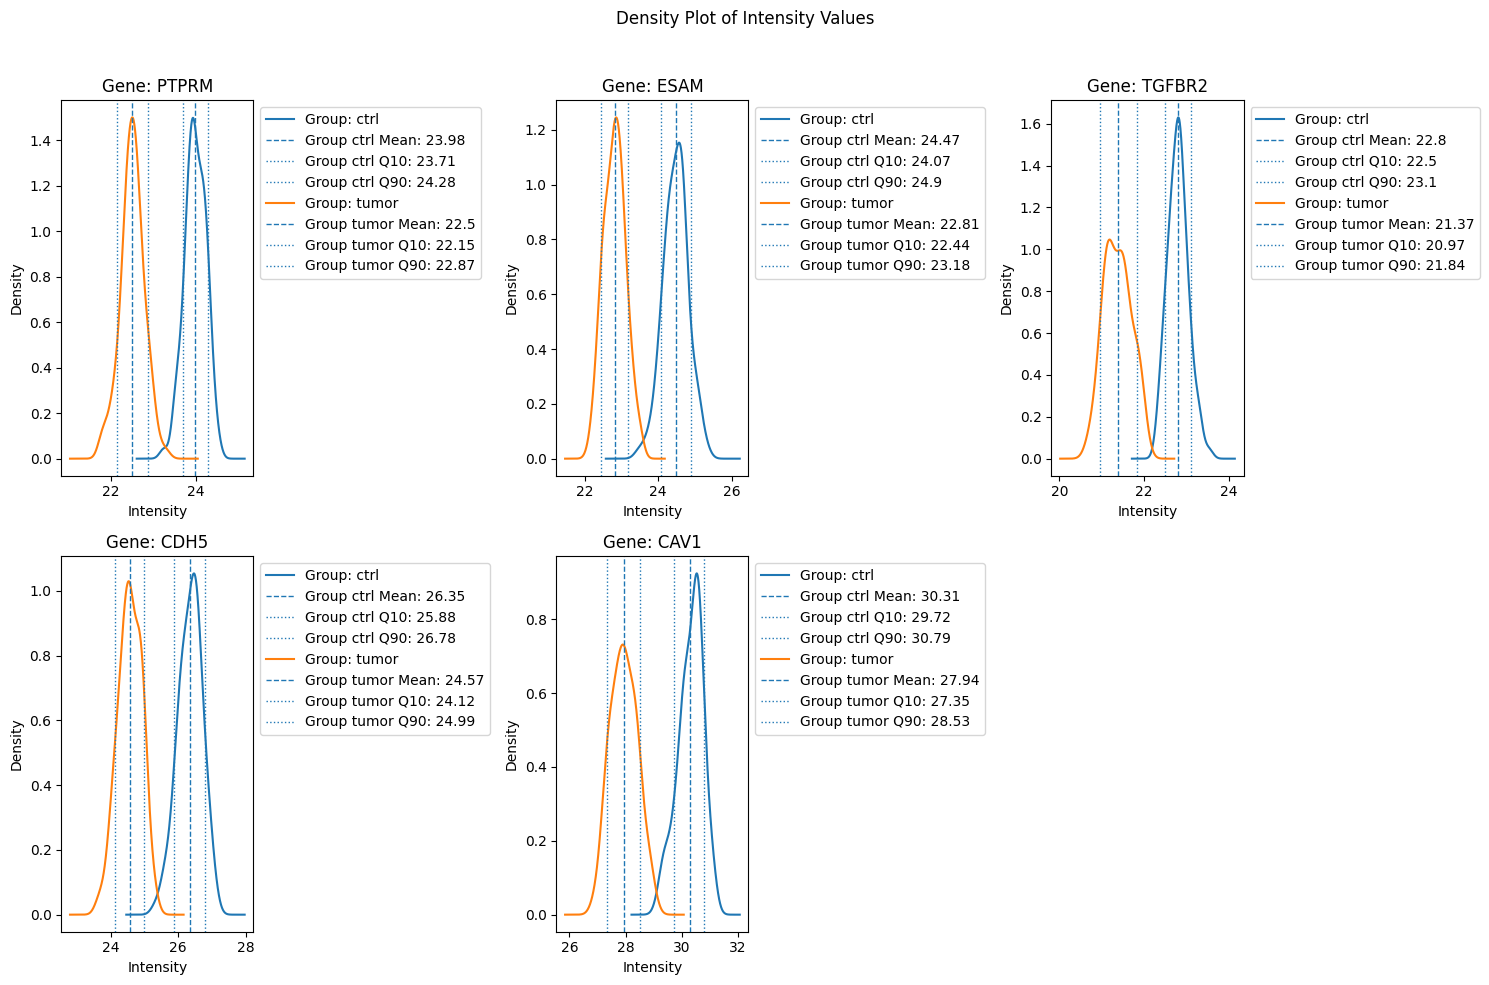

In [49]:
p = nc.visual.plot_density(df=proteomics_renamed, gene_ids=source_dict.keys(), id_column='gene_symbol', metadata=proteomics_meta)

All these receptors are downregulated in the tumor samples. Since the intensity distributions are quite separated between tumor and control samples, we might think that they are interesting in order to explain the mechanisms of disease we aim to capture.

Now, we can perform TF activity estimation and use them as downstream measurements. We will use decoupler-py coupled with the CollecTRI GRN.

In [50]:
collectri = dc.get_collectri()
tfs = collectri.source.values
decoupler_input = nc.utils.decoupler_formatter(de_transcr, 'stat')
dc_estimates, dc_pvals = dc.run_ulm(decoupler_input, collectri)
measurements = nc.utils.targetlayer_formatter(dc_estimates.T)

Now, we will perform Kinase activity estimation using PhosphoSitePlus. We will then use this information to evaluate the network on the basis of wether its nodes are overall more dysregulated than the overall phosphoproteome landscape.

In [51]:
phosphositeplus = nc.data.network.get_phosphositeplus()
phosphositeplus = phosphositeplus[phosphositeplus['KIN_ORGANISM'] == 'human']
phosphositeplus['target'] = phosphositeplus['SUB_GENE'] + '_' + phosphositeplus['SITE_+/-7_AA'].str.upper()
phosphositeplus.rename(columns={'KINASE': 'source'}, inplace=True)
phosphositeplus.drop_duplicates(subset=['source', 'target'], inplace=True)
phosphositeplus = phosphositeplus[['source', 'target']]
phosphositeplus.head()

,source,target
5,HRI,Eif2s1_MILLSELSRRRIRSI
6,HRI,EIF2S1_RILLSELSR______
7,HRI,EIF2S1_MILLSELSRRRIRSI
8,HRI,EIF2S1_IEGMILLSELSRRRI
9,PKCD,Sdc4_MKKKDEGSYDLGKKP


In [52]:
kinases = set(phosphositeplus.source) # get total number of kinases
len(kinases)

445

In [53]:
decoupler_input_kin = nc.utils.decoupler_formatter(de_phospho, 'stat') # get the actual number of inferred kinase activities
dc_estimates_kin, dc_pvals_kin = dc.run_zscore(decoupler_input_kin, phosphositeplus, weight=None)
kinase_activities = dc_estimates_kin.T
kinase_activities.head()
len(kinase_activities)

55

We could infer activities for 55 out of the 445 available kinases. For the remaining ones, there was not enough data available.

Lastly, now that we have our data ready, we can get the network from OmniPath.

In [54]:
network = nc.data.network.get_omnipath()
network = network[~network['source'].isin(tfs)] # we remove communication to the GRN layer
network.head()

graph = nc.utils.network_from_df(network)

## 3. Network inference

Now, we can perform network inference with some of the methods we already explored in previous vignette. We will store the networks in a dictionary to ease further downstream analysis.

In [55]:
networks = {}

In [56]:
networks['shortest_path'], shortest_paths_list = nc.methods.run_shortest_paths(graph, source_dict, measurements)

In [57]:
visualizer = nc.visual.NetworkXVisualizer(networks['shortest_path'])
visualizer.visualize_network(source_dict, measurements)

The network is too large to visualize, you can increase the max_nodes parameter if needed.


In [58]:
networks['shortest_sc_path'], shortest_sc_list = nc.methods.run_sign_consistency(networks['shortest_path'], shortest_paths_list, source_dict, measurements)

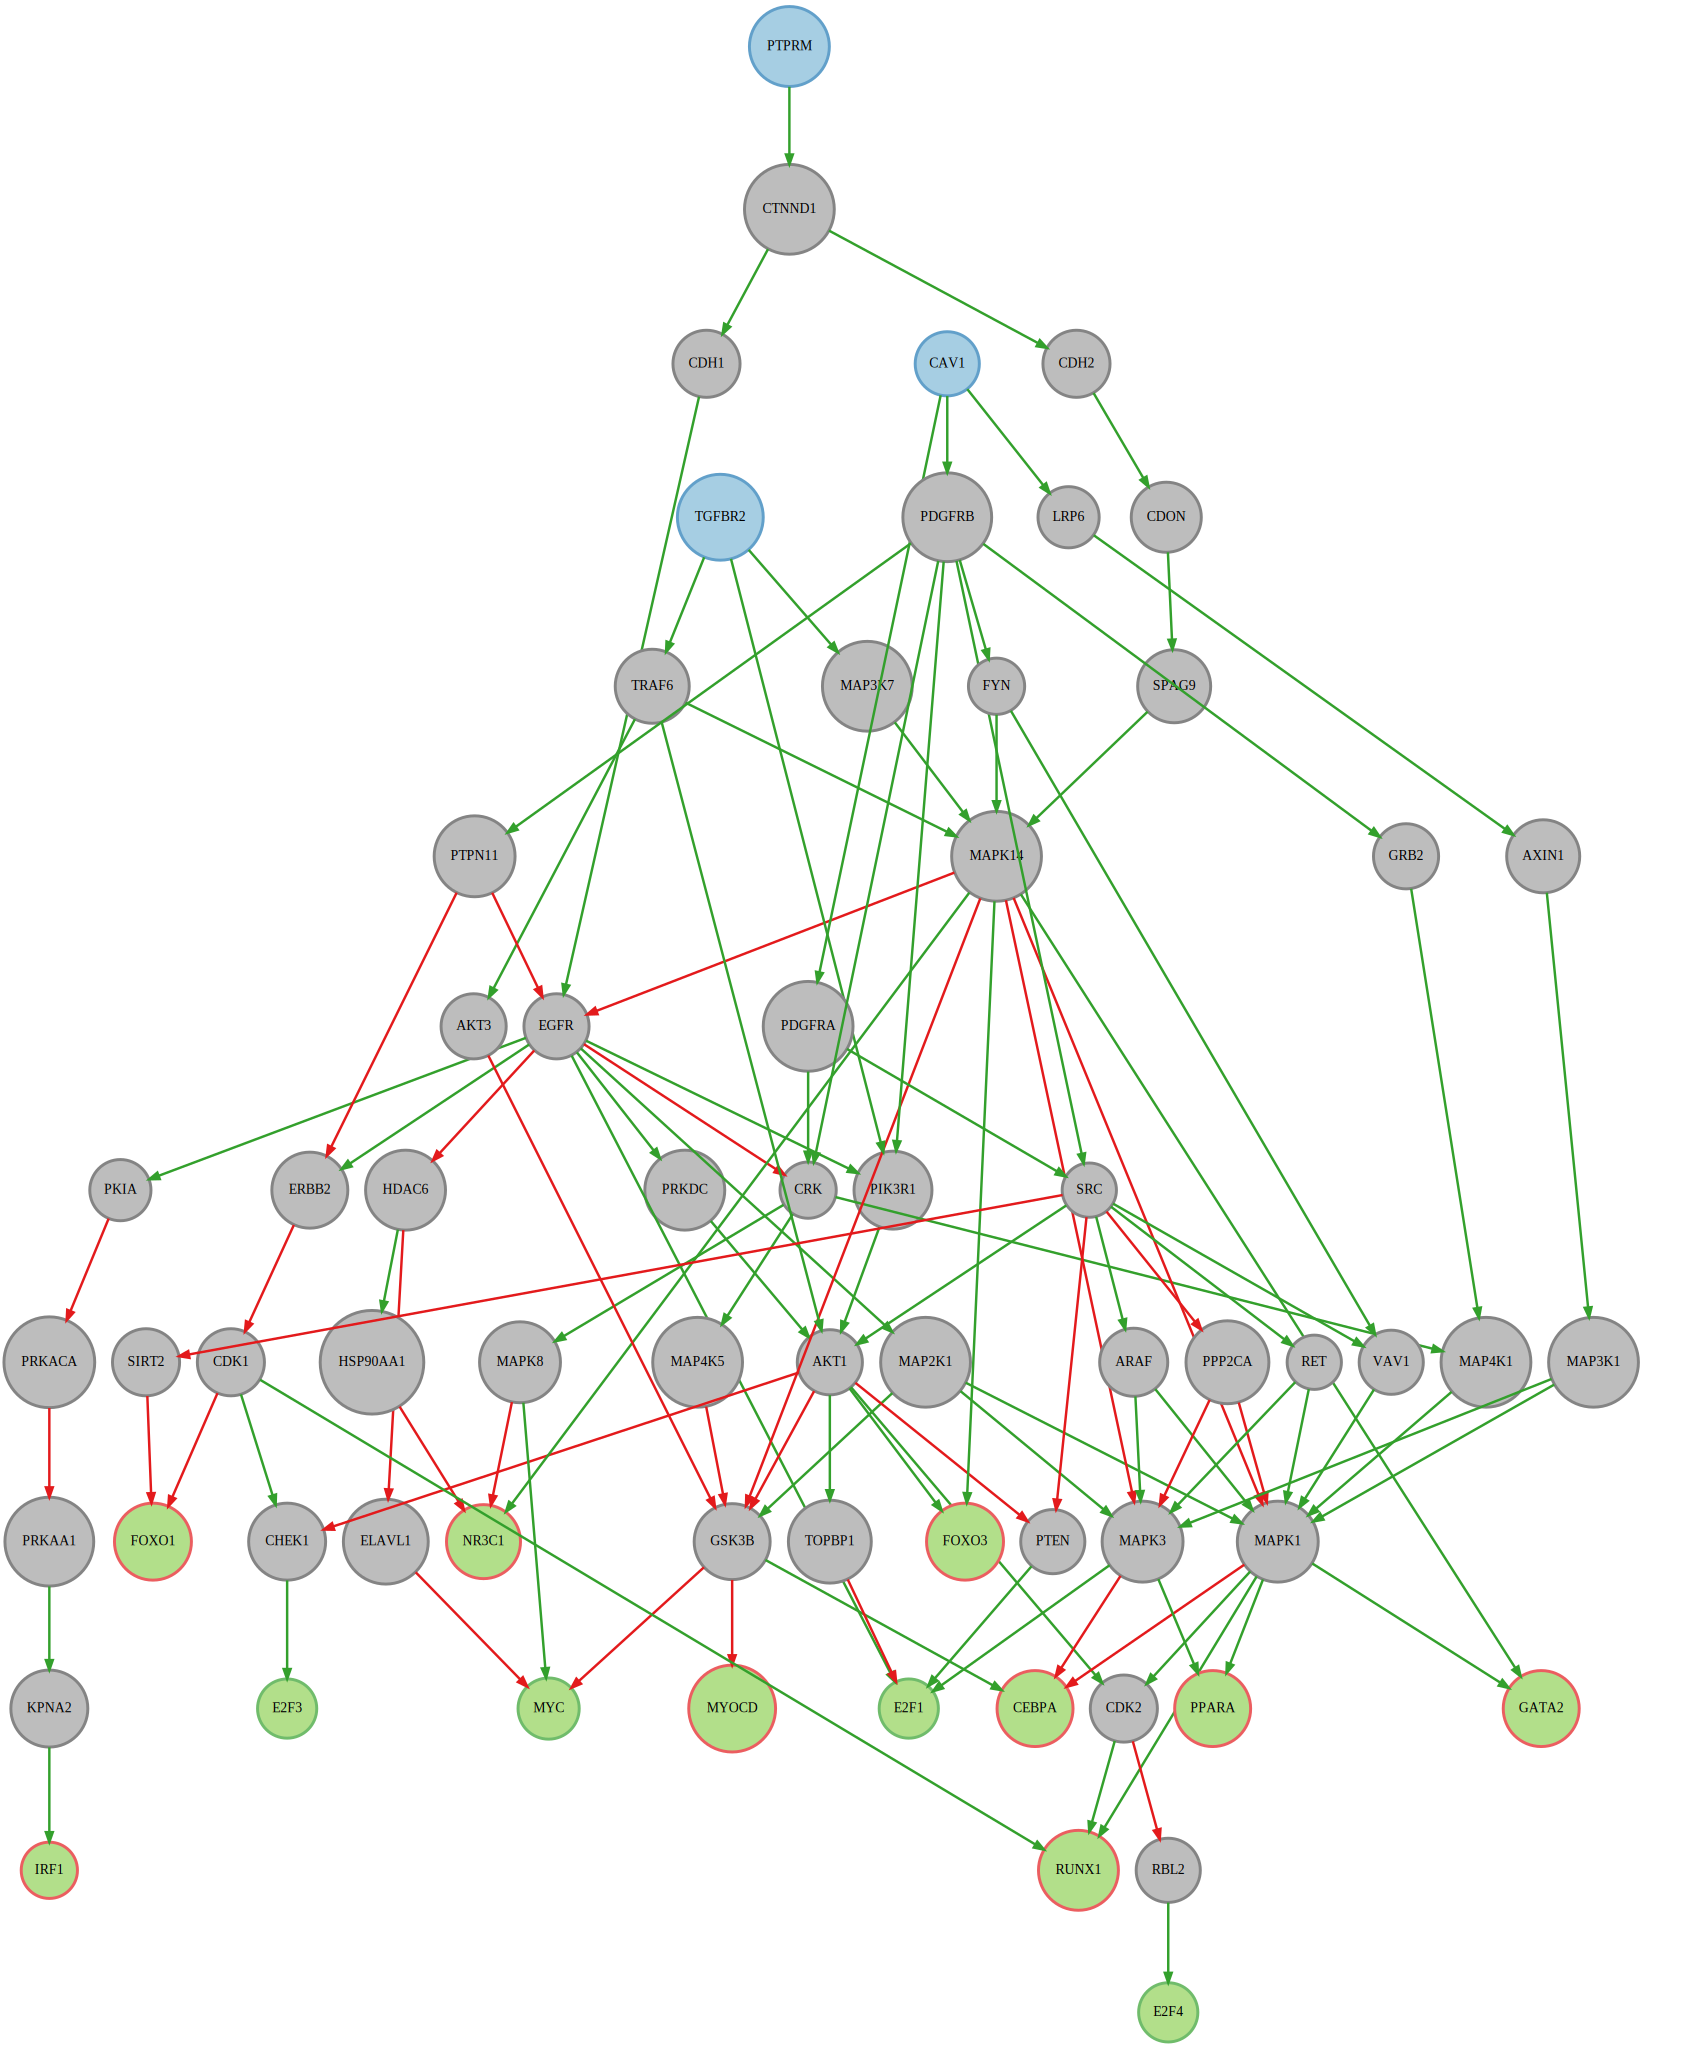

In [59]:
visualizer = nc.visual.NetworkXVisualizer(networks['shortest_sc_path'])
visualizer.visualize_network(source_dict, measurements, network_type='sign_consistent')

In [60]:
networks['all_paths'], all_paths_list = nc.methods.run_all_paths(graph, source_dict, measurements, depth_cutoff=6)

In [61]:
visualizer = nc.visual.NetworkXVisualizer(networks['all_paths'])
visualizer.visualize_network_simple(source_dict, measurements)

The network is too large to visualize, you can increase the max_nodes parameter if needed.


In [62]:
networks['all_sc_paths'], allpaths_sc_list = nc.methods.run_sign_consistency(networks['all_paths'], all_paths_list, source_dict, measurements)

In [63]:
visualizer = nc.visual.NetworkXVisualizer(networks['all_sc_paths'])
visualizer.visualize_network_simple(source_dict, measurements)

The network is too large to visualize, you can increase the max_nodes parameter if needed.


In [ ]:
networks['corneto_graph'] = nc.methods.run_corneto_carnival(graph, source_dict, measurements, betaWeight=0.01, solver='GUROBI')

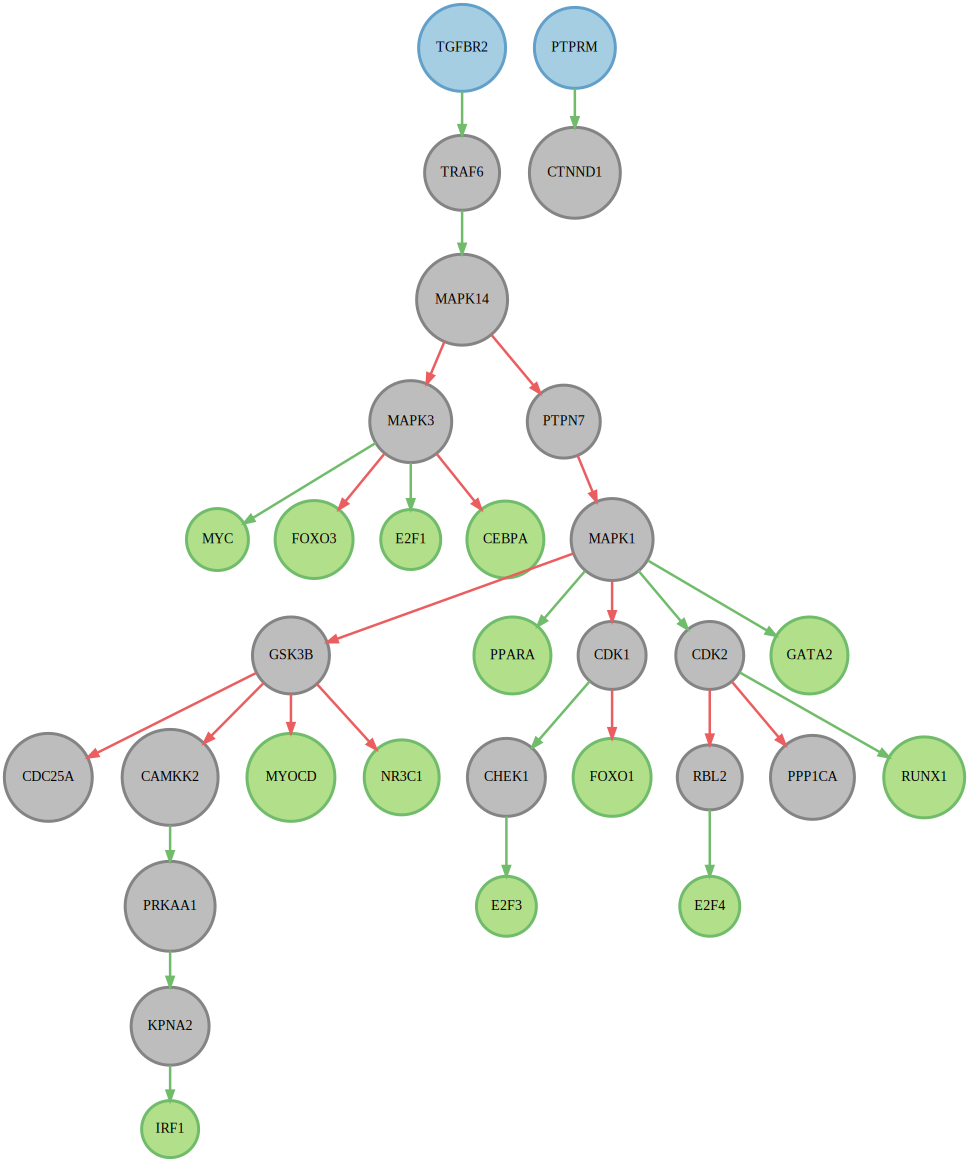

In [65]:
visualizer = nc.visual.NetworkXVisualizer(networks['corneto_graph'])
visualizer.visualize_network_simple(source_dict, measurements)

## 4. Network evaluation using level of dysregulation in the phosphoproteome.

Now, at last, we are in the position to test our hypotheses. In this section, we will use the kinase activities to evaluate whether the inferred networks capture a more extreme dysregulation status (understood as average kinase activity score for the nodes in the network, versus the overall kinase activity) than the random controls (node and measurement label shuffling, but keeping the topology of the network intact). For more information about this benchmark, please refer to the specific section in the [Evaluation strategies page](../benchmarks.html#recovery-of-dysregulated-kinases).

We will first create the random controls that will act as our baseline for the evaluation. We will infer 100 random networks, and then compute the average of all of them.

In [66]:
sp_random_controls = nc.eval.perform_random_controls(graph, nc.methods.run_shortest_paths, 100, 'shortest_path', source_dict=source_dict, target_dict=measurements, randomise_measurements=True, item_list=list(tfs))

In [43]:
ap_random_controls = nc.eval.perform_random_controls(graph, nc.methods.run_all_paths, 100, 'all_paths', source_dict=source_dict, target_dict=measurements, depth_cutoff=6, randomise_measurements=True, item_list=list(tfs))

In [44]:
combined_dict = {}
combined_dict.update(networks)
combined_dict.update(sp_random_controls)
combined_dict.update(ap_random_controls)

In [ ]:
phospho_results = nc.eval.get_metric_from_networks(combined_dict, nc.eval.get_phosphorylation_status, dataframe=kinase_activities)

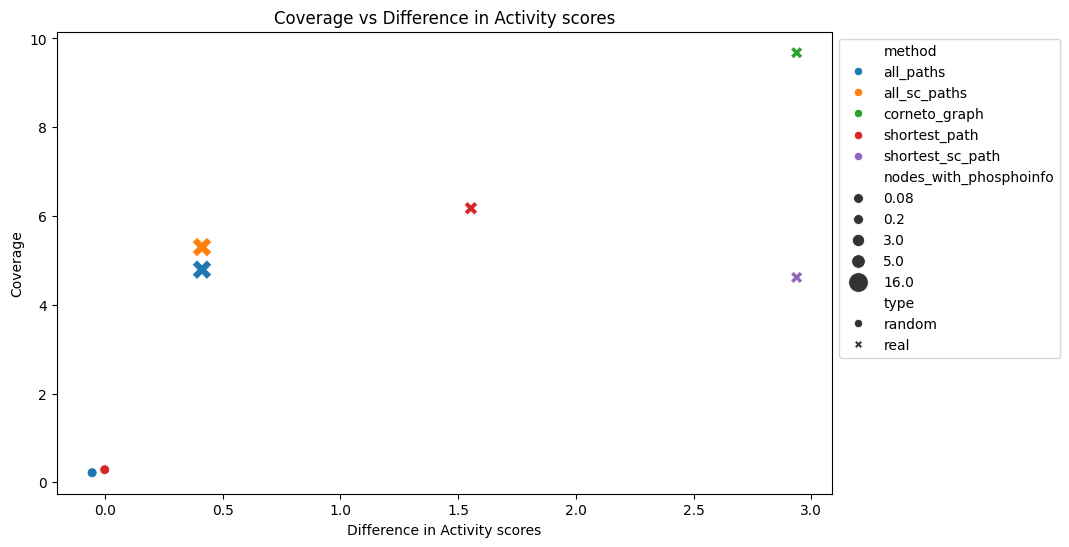

In [46]:
p = nc.visual.plot_scatter(phospho_results, x_col='diff_dysregulation')

The results show that our contextualised networks manage to recover a higher share of dysregulation, which means that in this scenario, the network methods perform much better than a random model, especially the CORNETO graph and shortest paths with sign consistency. CORNETO also gets the highest coverage, almost 10% of the nodes are active kinases. Therefore, under this assumption, CORNETO-Carnival would be the top performer.

<div class="alert alert-warning">

**Warning**
    
This approach has the flaw of having usually low coverage of kinase activities, thus the inferred dysregulation might not come from a representative set of kinases. This evaluation setting is still under development.

</div>

And that was it! Here, we conducted and end-to-end analysis of multiomics data, starting from raw intensities to contextualised networks, which we then evaluated. Now it is the time for you to explore the full potential of network contextualisation, and we hope that **Networkcommons** will be helpful along this journey. :)